In [4]:
%stop_session
%number_of_workers 20
%worker_type G.2X

Welcome to the Glue Interactive Sessions Kernel
For more information on available magic commands, please type %help in any new cell.

Please view our Getting Started page to access the most up-to-date information on the Interactive Sessions kernel: https://docs.aws.amazon.com/glue/latest/dg/interactive-sessions.html
Installed kernel version: 1.0.2 
There is no current session.
Previous number of workers: None
Setting new number of workers to: 20
Previous worker type: None
Setting new worker type to: G.2X


In [9]:
!mkdir -p /tmp/sedona
!curl -o /tmp/sedona/sedona-spark-shaded-3.0_2.12-1.5.1.jar "https://repo1.maven.org/maven2/org/apache/sedona/sedona-spark-shaded-3.0_2.12/1.5.1/sedona-spark-shaded-3.0_2.12-1.5.1.jar"
!curl -o /tmp/sedona/geotools-wrapper-1.5.1-28.2.jar "https://repo1.maven.org/maven2/org/datasyslab/geotools-wrapper/1.5.1-28.2/geotools-wrapper-1.5.1-28.2.jar"
!aws s3 sync /tmp/sedona/ s3://sftp-pipeline-bucket/sedona/libs/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 20.7M  100 20.7M    0     0   213M      0 --:--:-- --:--:-- --:--:--  214M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28.8M  100 28.8M    0     0   227M      0 --:--:-- --:--:-- --:--:--  227M
upload: sedona/geotools-wrapper-1.5.1-28.2.jar to s3://sftp-pipeline-bucket/sedona/libs/geotools-wrapper-1.5.1-28.2.jar
upload: sedona/sedona-spark-shaded-3.0_2.12-1.5.1.jar to s3://sftp-pipeline-bucket/sedona/libs/sedona-spark-shaded-3.0_2.12-1.5.1.jar


In [13]:
%additional_python_modules pandas==1.3.5,shapely==1.8.5,geopandas==0.11.1,keplergl==0.3.2,pydeck==0.8.0,attrs,matplotlib,descartes,apache-sedona==1.5.1
%extra_jars s3://sftp-pipeline-bucket/sedona/libs/sedona-spark-shaded-3.0_2.12-1.5.1.jar,s3://sftp-pipeline-bucket/sedona/libs/geotools-wrapper-1.5.1-28.2.jar
%spark_conf spark.serializer=org.apache.spark.serializer.KryoSerializer --conf spark.kryo.registrator=org.apache.sedona.core.serde.SedonaKryoRegistrator --conf spark.sql.extensions=org.apache.sedona.viz.sql.SedonaVizExtensions,org.apache.sedona.sql.SedonaSqlExtensions

Additional python modules to be included:
pandas==1.3.5
shapely==1.8.5
geopandas==0.11.1
keplergl==0.3.2
pydeck==0.8.0
attrs
matplotlib
descartes
apache-sedona==1.5.1
Extra jars to be included:
s3://sftp-pipeline-bucket/sedona/libs/sedona-spark-shaded-3.0_2.12-1.5.1.jar
s3://sftp-pipeline-bucket/sedona/libs/geotools-wrapper-1.5.1-28.2.jar
Previous Spark configuration: None
Setting new Spark configuration to: spark.serializer=org.apache.spark.serializer.KryoSerializer --conf spark.kryo.registrator=org.apache.sedona.core.serde.SedonaKryoRegistrator --conf spark.sql.extensions=org.apache.sedona.viz.sql.SedonaVizExtensions,org.apache.sedona.sql.SedonaSqlExtensions
s3://sftp-pipeline-bucket/sedona/libs/sedona-spark-shaded-3.0_2.12-1.5.1.jar,s3://sftp-pipeline-bucket/sedona/libs/geotools-wrapper-1.5.1-28.2.jar


In [8]:
from sedona.spark import *
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl

config = SedonaContext.builder().getOrCreate()
sedona = SedonaContext.create(config)

In [2]:
osm = sedona.read.orc("s3://osm-pds/planet/planet-latest.orc")
osm.printSchema()

root
 |-- id: long (nullable = true)
 |-- type: string (nullable = true)
 |-- tags: map (nullable = true)
 |    |-- key: string
 |    |-- value: string (valueContainsNull = true)
 |-- lat: decimal(9,7) (nullable = true)
 |-- lon: decimal(10,7) (nullable = true)
 |-- nds: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- ref: long (nullable = true)
 |-- members: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- type: string (nullable = true)
 |    |    |-- ref: long (nullable = true)
 |    |    |-- role: string (nullable = true)
 |-- changeset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- uid: long (nullable = true)
 |-- user: string (nullable = true)
 |-- version: long (nullable = true)
 |-- visible: boolean (nullable = true)


In [11]:
nodes = osm.where("type == 'node' and lon between -122.45 and -122.25 and lat between 47.5 and 47.7") \
    .withColumn("geom", expr("st_makepoint(lon, lat)")) \
    .selectExpr("id as node_id", "geom")
nodes.show()

+--------+--------------------+
| node_id|                geom|
+--------+--------------------+
|29445653|POINT (-122.31968...|
|29445655|POINT (-122.32113...|
|29445656|POINT (-122.32184...|
|29445657|POINT (-122.32204...|
|29445659|POINT (-122.32218...|
|29445660|POINT (-122.32232...|
|29445661|POINT (-122.32236...|
|29445662|POINT (-122.32250...|
|29445663|POINT (-122.32263...|
|29447666|POINT (-122.30465...|
|29447667|POINT (-122.30523...|
|29447668|POINT (-122.30622...|
|29447670|POINT (-122.30891...|
|29449048|POINT (-122.27805...|
|29449050|POINT (-122.27946...|
|29449412|POINT (-122.31663...|
|29449415|POINT (-122.31409...|
|29449419|POINT (-122.31050...|
|29449421|POINT (-122.30915...|
|29449422|POINT (-122.30804...|
+--------+--------------------+
only showing top 20 rows


In [12]:
ways = osm.where("type = 'way' and tags.highway is not null") \
    .selectExpr("id as way_id", "tags as way_tags", "posexplode(nds.ref) as (idx, node_id)")
ways.show()

+------+--------------------+---+----------+
|way_id|            way_tags|idx|   node_id|
+------+--------------------+---+----------+
|    37|{abutters -> resi...|  0|    200511|
|    37|{abutters -> resi...|  1|1025338193|
|    37|{abutters -> resi...|  2| 177231081|
|    37|{abutters -> resi...|  3| 177081428|
|    37|{abutters -> resi...|  4|1025338209|
|    37|{abutters -> resi...|  5| 177081440|
|    37|{abutters -> resi...|  6|    200512|
|    37|{abutters -> resi...|  7|1025338201|
|    37|{abutters -> resi...|  8|    200514|
|    37|{abutters -> resi...|  9|1025338210|
|    37|{abutters -> resi...| 10|    200517|
|    37|{abutters -> resi...| 11|1025338191|
|    37|{abutters -> resi...| 12|    200515|
|    37|{abutters -> resi...| 13|    200526|
|    37|{abutters -> resi...| 14|    200527|
|    37|{abutters -> resi...| 15|    200528|
|    37|{abutters -> resi...| 16|    200530|
|    37|{abutters -> resi...| 17|1082909509|
|    37|{abutters -> resi...| 18|1082909488|
|    37|{a

In [13]:
lines = ways.join(nodes, "node_id") \
    .groupBy("way_id") \
    .agg(first("way_tags").alias("way_tags"), 
         transform(array_sort(collect_list(struct("idx", "geom"))), lambda elem, _: elem.getField("geom")).alias("geoms")
    ) \
    .where(size("geoms") >= 2) \
    .selectExpr("way_id", "way_tags", "st_makeline(geoms) as geom")
    .withColumn("maxspeed", regexp_extract(col("way_tags.maxspeed"), r'(\d+)', 1).cast(IntegerType())) \
    .fillna(0) \
    .orderBy(asc("maxspeed"))

lines.cache()
lines.show()

+-------+--------------------+--------------------+
| way_id|            way_tags|                geom|
+-------+--------------------+--------------------+
|4744038|{bicycle -> no, b...|LINESTRING (-122....|
|4864595|{access:lanes -> ...|LINESTRING (-122....|
|6345429|{highway -> resid...|LINESTRING (-122....|
|6348165|{cycleway:both ->...|LINESTRING (-122....|
|6358495|{highway -> resid...|LINESTRING (-122....|
|6361213|{bicycle -> desig...|LINESTRING (-122....|
|6373440|{access -> privat...|LINESTRING (-122....|
|6376887|{cycleway:both ->...|LINESTRING (-122....|
|6385862|{highway -> resid...|LINESTRING (-122....|
|6399189|{access -> privat...|LINESTRING (-122....|
|6403886|{highway -> resid...|LINESTRING (-122....|
|6415467|{highway -> resid...|LINESTRING (-122....|
|6417121|{highway -> servi...|LINESTRING (-122....|
|6425168|{highway -> resid...|LINESTRING (-122....|
|6435557|{highway -> resid...|LINESTRING (-122....|
|6440660|{highway -> resid...|LINESTRING (-122....|
|6443184|{hi

<AxesSubplot:>



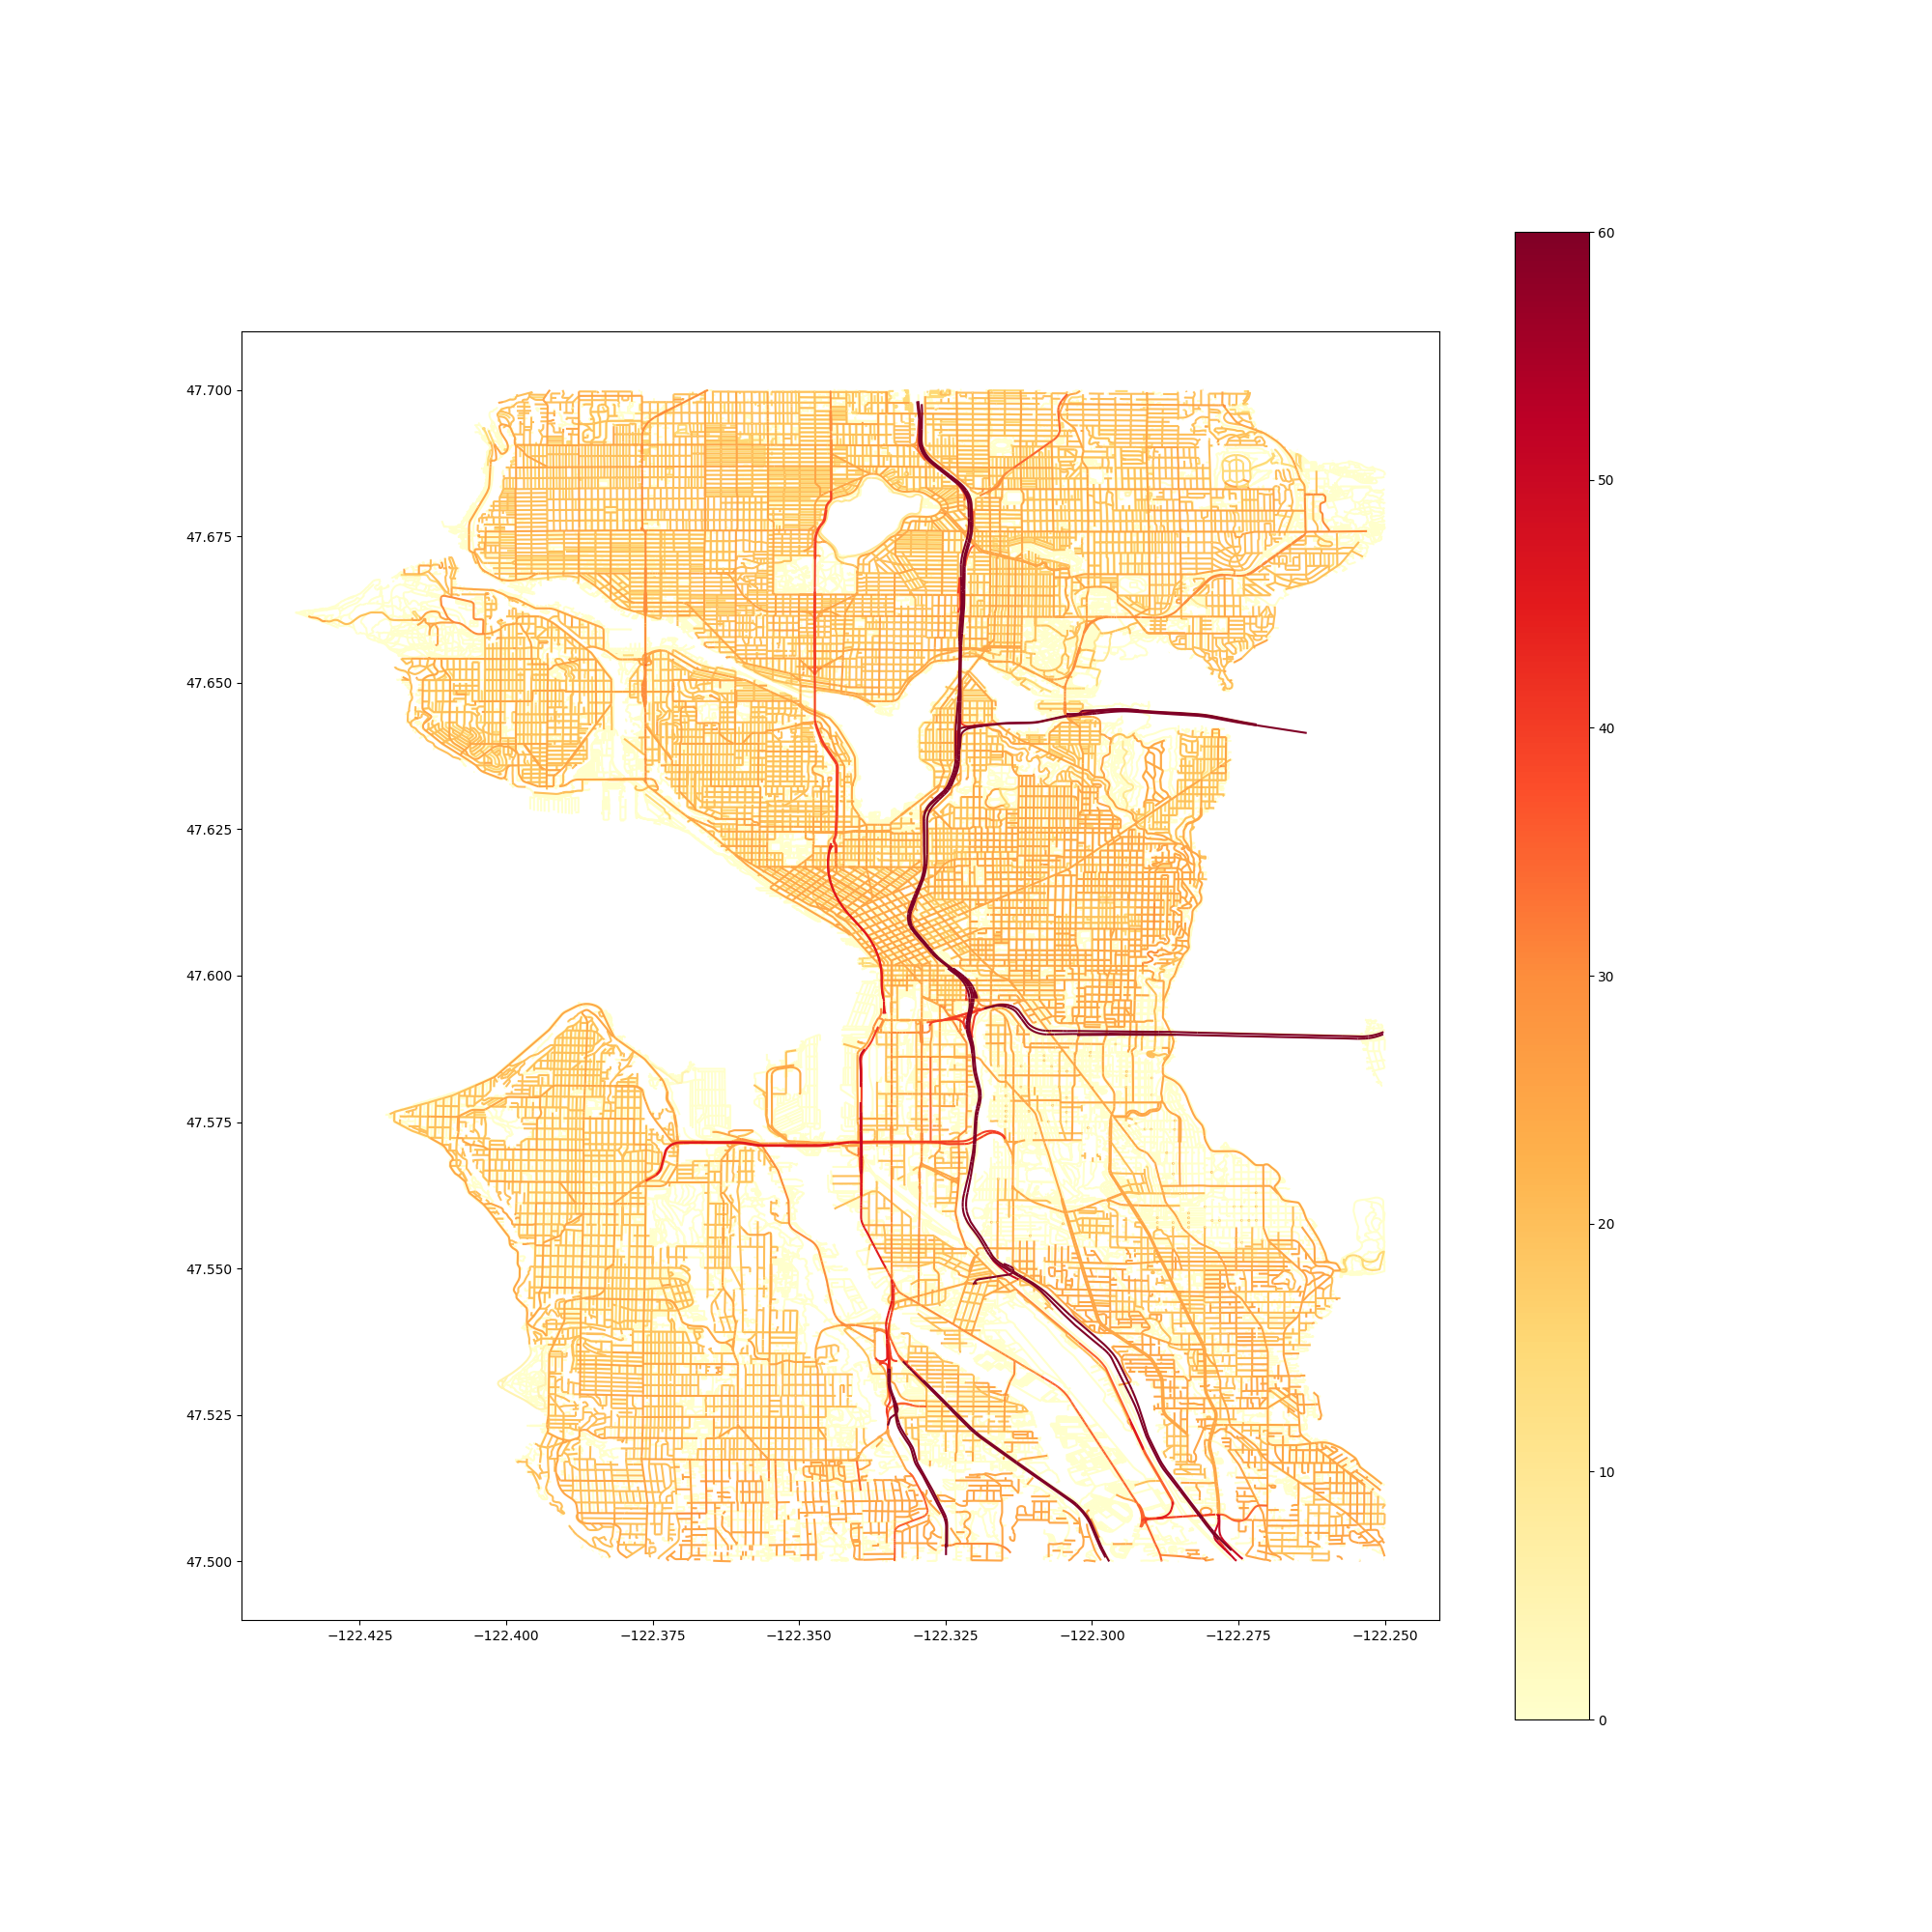

In [10]:
gdf = gpd.GeoDataFrame(lines.toPandas(), geometry="geom")
gdf.plot(figsize=(20,20), column="maxspeed", cmap=mpl.cm.YlOrRd, legend=True)

%matplot plt

In [16]:
%stop_session

Stopping session: 85da4cb7-8e3c-44a6-9861-7cad402241e1
Stopped session.
